# Week 6

**`Agent::model-free::DQN`**
- binary trader
- softmax policy

In [1]:
# change current working directory
%cd ..

/Users/omega/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# trading environment
from qtrader.envs import TradingEnv
# agent base class
from qtrader.agents.base import Agent
# NumPy implementation of Softmax
from qtrader.utils.numpy import softmax
# OpenAI spaces
from qtrader.utils.gym import cardinalities
# OpenAI environment automated execution
from qtrader.utils.gym import run
# one-hot encoded actions
from qtrader.utils.gym import one_hot

# YAML parser
import yaml
# built-in containers
from collections import deque
# random number generator
import random

# scientific programming
import numpy as np
import pandas as pd

# deep-learning framework
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# OpenAI Gym
import gym

# # visualization
import matplotlib.pyplot as plt

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_6.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")
print(f"number of episodes: {config['num_episodes']}")
print(f"number of neurons in hidden layer: {config['hidden_layer']}")
print(f"replay memory capacity: {config['capacity']}")

start date: 2017-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'GS', 'MMM']
number of episodes: 250
number of neurons in hidden layer: 50
replay memory capacity: 3000


## `DQNAgent`

Generic Deep Q-Network agent.

In [4]:
class Brain(nn.Module):
    """Neural network used in DQN."""

    def __init__(self, in_dim, hidden_dim, out_dim, lr):
        super(Brain, self).__init__()
        # network layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        # optimizer
        self.optimizer = optim.Adam(self.parameters(),
                                    lr=lr)
        # objective function
        self.criterion = nn.MSELoss()

    def forward(self, x):
        """Inference."""
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

    def fit(self, X, y):
        """Training."""
        if isinstance(y, np.ndarray):
            y = torch.from_numpy(y)
        self.optimizer.zero_grad()
        # prediction
        y_hat = self(X)
        # loss function
        loss = self.criterion(y_hat, y)
        # get gradients
        loss.backward()
        # update weights
        self.optimizer.step()

In [5]:
class DQNAgent(Agent):
    
    _id = 'DQN'

    def __init__(self, state_size, action_size, binary=False, **kwargs):
        self.state_size = state_size
        self.action_size = action_size
        # hyperparameters for DQN
        self.gamma = kwargs.get('gamma', 0.99)
        self.lr = kwargs.get('lr', 0.001)
        self.epsilon = kwargs.get('epsilon', 1.0)
        self.epsilon_decay = kwargs.get('epsilon_decay', 0.999)
        self.epsilon_min = kwargs.get('epsilon_min', 0.01)
        self.batch_size = kwargs.get('batch_size', 64)
        self.train_start = kwargs.get('train_start', 1000)
        # replay memory
        self.memory = deque(maxlen=kwargs.get('capacity', 2000))

        # main and target models
        self.model = Brain(self.state_size, kwargs.get('hidden_layer', 24), self.action_size, self.lr)
        self.model.double()
        self.target_model = Brain(
            self.state_size, kwargs.get('hidden_layer', 24), self.action_size, self.lr)
        self.target_model.double()

        # init target model
        self.update_target_model()
        
        # binary actions
        self._binary = binary
    
    ###########
    # Private
    ###########

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model(state).detach().numpy()[0]
            return np.argmax(q_value)

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay

    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        update_input = torch.from_numpy(update_input)
        target = self.model(update_input).detach().numpy()
        update_target = torch.from_numpy(update_target)
        target_val = self.target_model(update_target).detach().numpy()

        for i in range(batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + \
                    self.gamma * np.amax(target_val[i])

        self.model.fit(update_input, target)
    
    ###########
    # Public
    ###########

    def act(self, observation):
        if isinstance(observation, dict):
            observation = observation['prices']
        if isinstance(observation, pd.Series):
            observation = observation.values
        observation = np.reshape(observation, [1, self.state_size])
        _action = self.get_action(observation)
        if self._binary:
            return one_hot(_action, self.action_size)
        else:
            return _action

    def observe(self, observation, action, reward, done, next_observation):
        if isinstance(observation, dict):
            observation = observation['prices']
        if isinstance(observation, pd.Series):
            observation = observation.values
        if isinstance(next_observation, dict):
            next_observation = next_observation['prices']
        if isinstance(next_observation, pd.Series):
            next_observation = next_observation.values
        observation = np.reshape(observation, [1, self.state_size])
        next_observation = np.reshape(
            next_observation, [1, self.state_size])
        if self._binary:
            action = np.argmax(action)
        self.append_sample(observation, action, reward, next_observation, done)
        self.train_model()

    def end_episode(self):
        self.update_target_model()

### `CartPole-v1`

Proof of concept on a standard environment, the **CartPole-v1**.

In [6]:
# initialize environment
env = gym.make('CartPole-v1')
# get environment spaces
observation_space, action_space = cardinalities(env)
# initialize agent
agent = DQNAgent(observation_space, action_space)
# execute environment
rewards, actions = run(env, agent, config['num_episodes'], True, False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


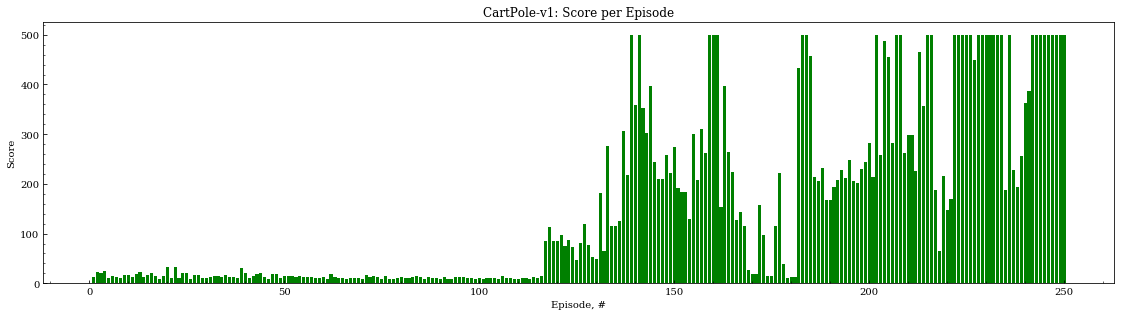

In [7]:
# initialize figure & axes
fig, axes = plt.subplots(figsize=(19.2, 4.8))
# plot cumulative reward per-episode
for j in range(len(rewards)):
    axes.bar(j+1, sum(rewards[j]), color='g')
# axes settings
axes.set(title='CartPole-v1: Score per Episode', ylabel='Score', xlabel='Episode, #');

### `TradingEnv`

Evaluation on the custom trading environment, the **TradingEnv**.

In [8]:
# initialize environment
env = TradingEnv(universe=config['tickers'],
                 trading_period=config['freq'],
                 start_date=config['start_date'],
                 csv=config['csv_file_prices'])
# get environment spaces
observation_space, action_space = cardinalities(env)
# initialize agent
agent = DQNAgent(observation_space, action_space, binary=True,
                 hidden_layer=config['hidden_layer'],
                 capacity=config['capacity'])
# execute environment
rewards, actions = run(env, agent, config['num_episodes'], True, False)

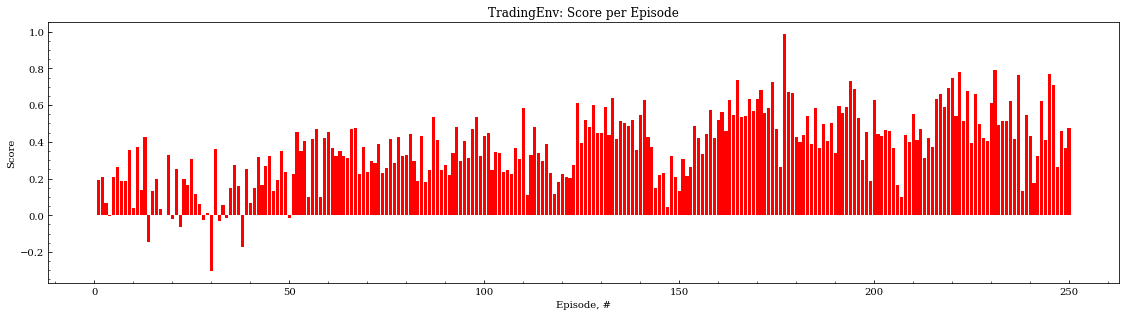

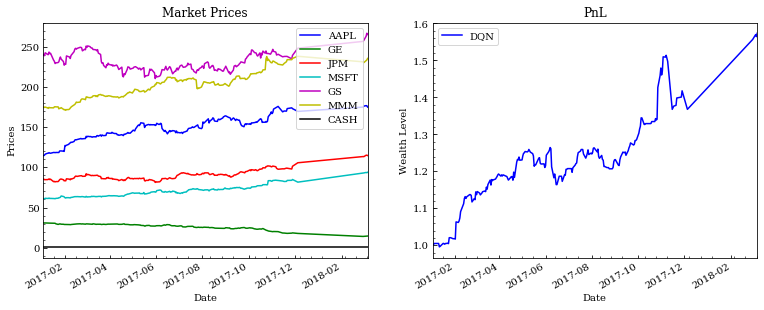

In [9]:
# initialize figure & axes
fig, axes = plt.subplots(figsize=(19.2, 4.8))
# plot cumulative reward per-episode
for j in range(len(rewards)):
    axes.bar(j+1, sum(rewards[j]), color='r')
# axes settings
axes.set(title='TradingEnv: Score per Episode', ylabel='Score', xlabel='Episode, #')
# visualize
env.render()

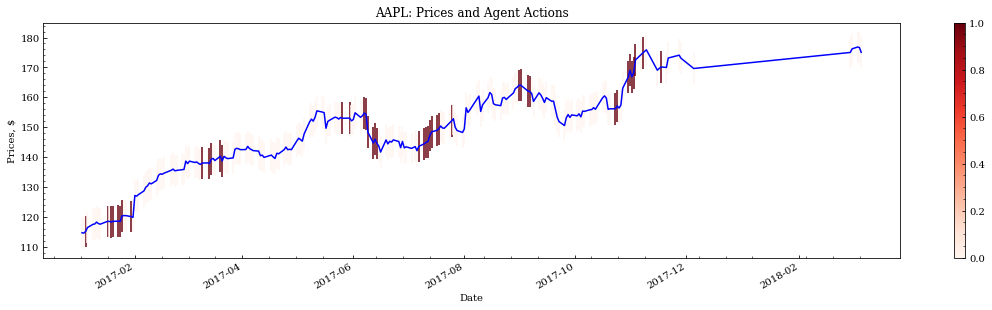

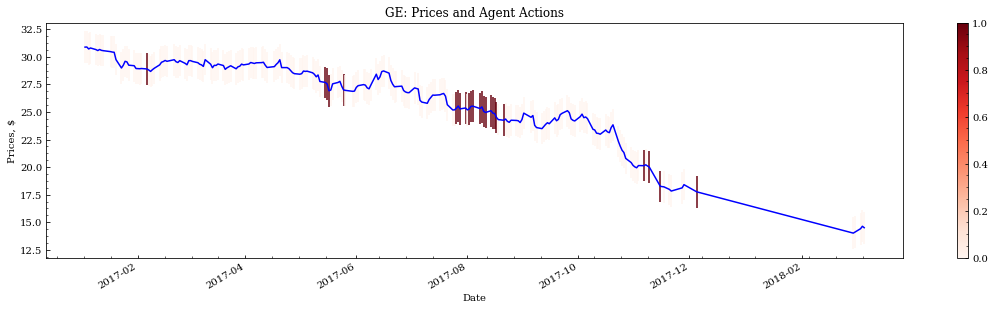

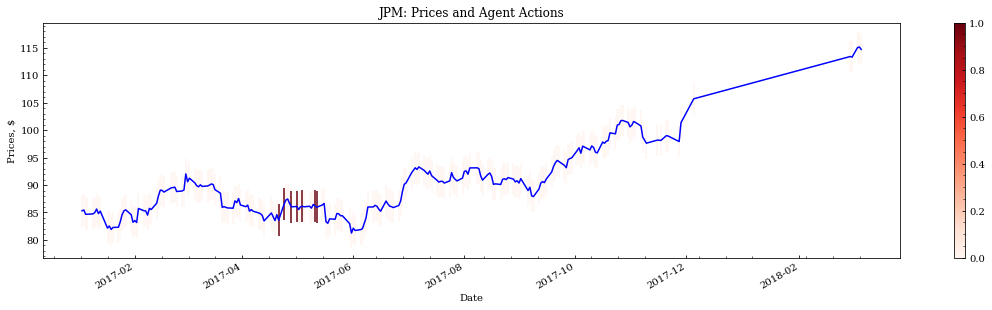

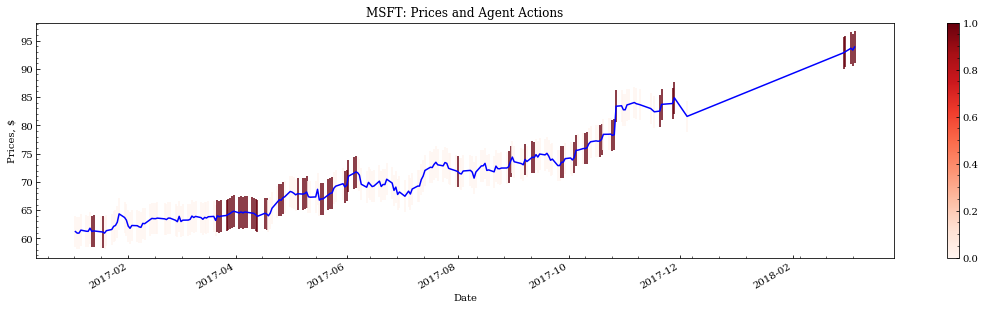

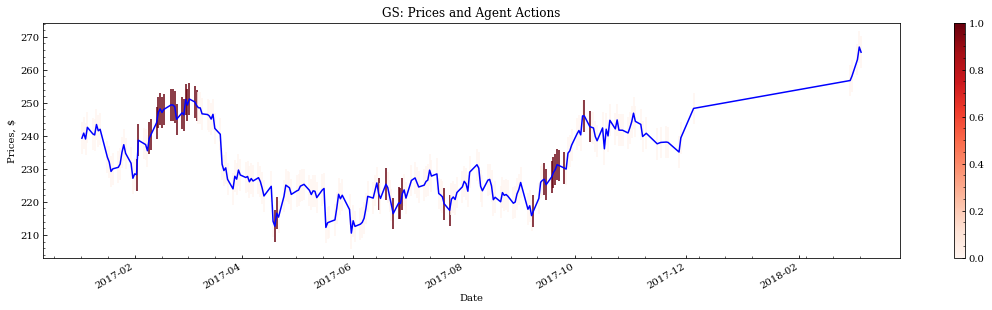

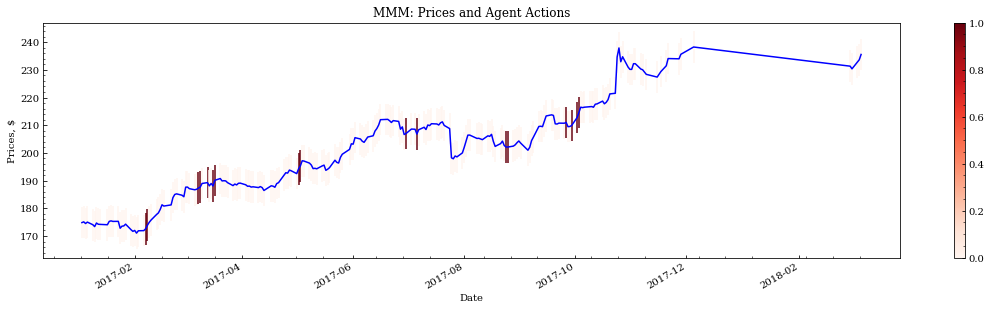

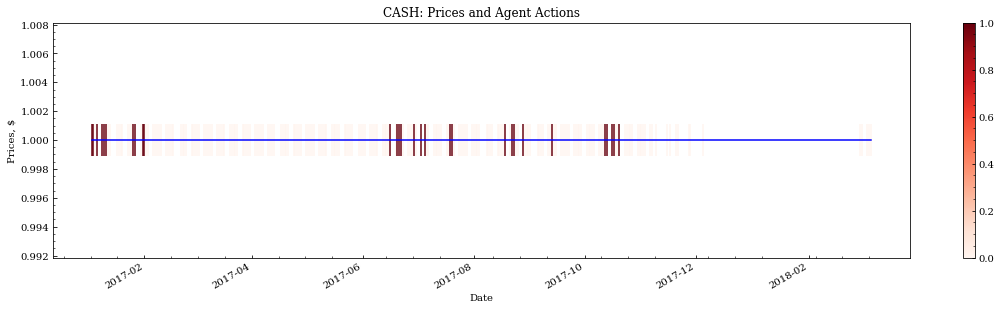

In [10]:
for asset in env.universe:
    # access episode actions
    acts = env.agents[agent.name].actions[asset]

    fig, ax = plt.subplots(figsize=(19.2, 4.8))
    env._prices[asset].plot(ax=ax)
    sc = ax.scatter(env._prices[asset].index,
                    env._prices[asset].values,
                    c=acts.values,
                    cmap=plt.cm.Reds,
                    marker='|',
                    s=1000,
                    vmin=0,
                    vmax=1)
    ax.set(ylabel='Prices, $', title='%s: Prices and Agent Actions' % asset)
    fig.colorbar(sc, ax=ax)